# Baysian Two-way Fixed Effects

- 階層ベイズモデル 不均一分散
- 階層ベイズモデル 均一分散
- 階層ベイズモデル 不均一分散 加重最小2乗法
- GLMM 不均一分散
- GLM 均一分散

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')
figsize = (10, 5)

In [2]:
filepath = '../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)

# 欠損値を削除
df = df.dropna(subset=['population'])

# 島をカテゴリ化
df.island_ids = df.island_ids.astype(str)
df.island_ids = df.island_ids.map(str.strip)
island_ids, mn_island_ids = df.island_ids.factorize()
# 年をカテゴリ化
df.year = df.year.astype(str)
df.year = df.year.map(str.strip)
year, mn_years = df.year.factorize()

<Axes: xlabel='log_pop', ylabel='Count'>

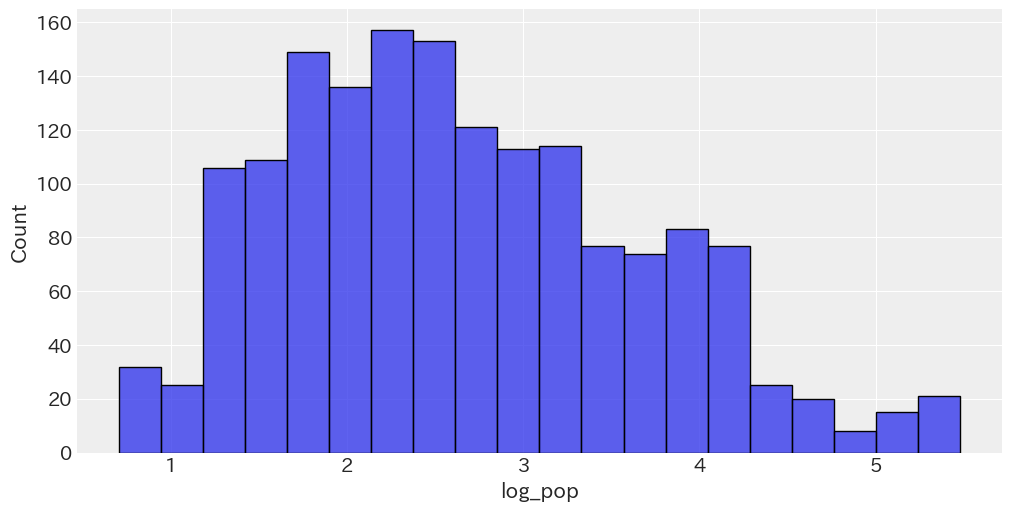

In [3]:
log_pop_scaled = df['log_pop'] / df['log_pop'].std()

fig, ax = plt.subplots(figsize=figsize)
sns.histplot(log_pop_scaled, ax=ax)

In [13]:
log_pop_scaled.describe()

count    1615.000000
mean        2.652602
std         1.000000
min         0.708497
25%         1.878817
50%         2.514469
75%         3.325693
max         5.476530
Name: log_pop, dtype: float64

## TWFE

$$
\log{Y^*_{it}} = \log{Y_{it}} - \bar{\log{{Y}_{i}}}
$$

$$
\begin{aligned}
\log{Y^*_{it}} &\sim \mathcal{t}(\nu, \mu_{it}, \sigma^2) \\
\mu_{it} &= \beta \cdot T_{it} \\
\beta &\sim \mathcal{N}(0, 1) \\
\nu &\sim \mathcal{Exponential}(\lambda = 1/10) \\
\sigma &\sim \mathcal{Cauchy}^+(\beta=1) \\
\end{aligned}
$$

## 階層ベイズモデル 不均一分散

In [46]:
# 島をカテゴリ化
df.island_ids = df.island_ids.astype(str)
df.island_ids = df.island_ids.map(str.strip)
island_ids, mn_island_ids = df.island_ids.factorize()
# 年をダミー化
year_dummies = dmatrix('C(year)-1', df, return_type='dataframe')

COORDS = {'y': df.index, 'X': df.index, 'island_id': mn_island_ids, 'year': year_dummies.columns}

with pm.Model(coords=COORDS) as model_h_hetero:
    # data
    log_pop = pm.Data('log_pop', df['log_pop'], dims='y')
    island_ids = pm.Data('island_ids', island_ids, dims='X')
    treatment = pm.Data('treatment', df['after_treatment'], dims='X')

    # priors
    # random effects
    mu_island = pm.Normal('mu_island', mu=0, sigma=1)
    sigma_island = pm.HalfCauchy('sigma_island', beta=1)
    z_island = pm.Normal('z_island', mu=0, sigma=1, dims='island_id')
    island_effect = pm.Deterministic('island_effect', mu_island + sigma_island * z_island, dims='island_id')

    sigma_global = pm.HalfCauchy('sigma_global', beta=1)
    sigma = pm.HalfCauchy('sigma', beta=sigma_global, dims='island_id')

    # fixed effects
    beta = pm.Normal('beta', mu=0, sigma=1)
    year_effects = pm.Normal('year_effects', mu=0, sigma=1, dims='year')
    nu = pm.Gamma('nu', alpha=2, beta=0.1)

    # expectation
    mu = beta * treatment + island_effect[island_ids] + pm.math.dot(year_dummies, year_effects)

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma[island_ids], observed=log_pop)

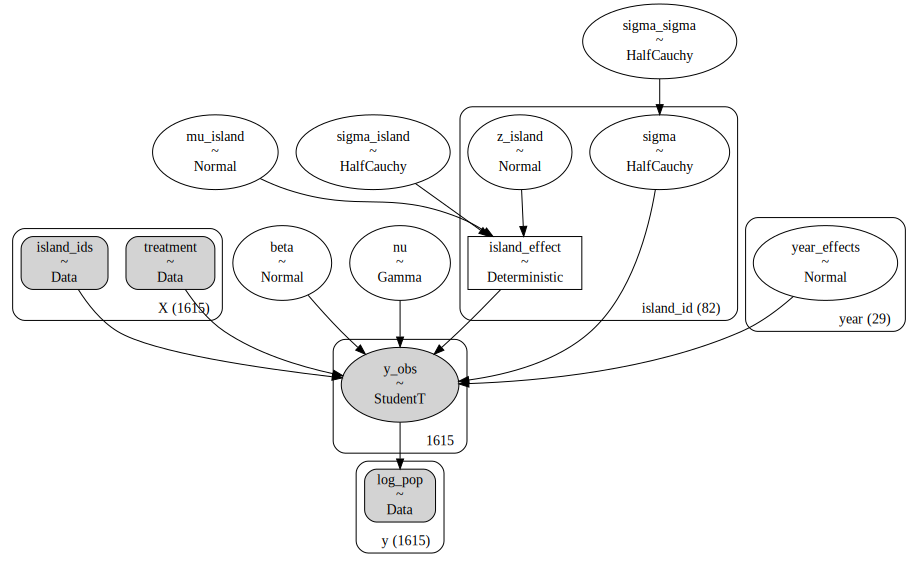

In [47]:
pm.model_to_graphviz(model_h_hetero)

In [48]:
with model_h_hetero:
    trace_h_hetero = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        nuts_sampler='numpyro',
        random_seed=42,
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [49]:
az.to_netcdf(trace_h_hetero, '../../data/processed/trace_h_hetero_20250109.nc')

'../../data/processed/trace_h_hetero_20250109.nc'

In [50]:
az.summary(trace_h_hetero, var_names=['beta', 'nu', 'sigma_sigma', 'mu_island', 'sigma_island', 'year_effects'], hdi_prob=.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  \
beta                         0.120  0.019     0.080      0.157      0.000   
nu                           2.967  0.358     2.313      3.653      0.007   
sigma_sigma                  0.117  0.017     0.087      0.150      0.000   
mu_island                    5.116  0.283     4.524      5.651      0.022   
sigma_island                 2.070  0.166     1.763      2.414      0.009   
year_effects[C(year)[1960]]  0.898  0.215     0.458      1.296      0.010   
year_effects[C(year)[1965]]  0.826  0.215     0.402      1.248      0.010   
year_effects[C(year)[1970]]  1.123  0.174     0.765      1.454      0.010   
year_effects[C(year)[1975]]  0.977  0.173     0.620      1.312      0.010   
year_effects[C(year)[1980]]  0.816  0.176     0.462      1.159      0.010   
year_effects[C(year)[1985]]  0.694  0.174     0.333      1.024      0.010   
year_effects[C(year)[1990]]  0.577  0.173     0.229      0.917      0.010   
year_effects[C(year)[1995]]  0.375  0.173     0.024      0.713      0.010   
year_effects[C(year)[2000]]  0.205  0.173    -0.139      0.548      0.010   
year_effects[C(year)[2001]]  0.246  0.173    -0.115      0.571      0.010   
year_effects[C(year)[2002]]  0.224  0.173    -0.130      0.556      0.010   
year_effects[C(year)[2003]]  0.189  0.173    -0.155      0.535      0.010   
year_effects[C(year)[2004]]  0.166  0.173    -0.191      0.497      0.010   
year_effects[C(year)[2005]]  0.131  0.173    -0.226      0.460      0.010   
year_effects[C(year)[2006]]  0.105  0.173    -0.255      0.431      0.010   
year_effects[C(year)[2007]]  0.080  0.173    -0.276      0.410      0.010   
year_effects[C(year)[2008]]  0.035  0.173    -0.328      0.360      0.010   
year_effects[C(year)[2009]] -0.004  0.173    -0.373      0.315      0.010   
year_effects[C(year)[2010]] -0.043  0.173    -0.398      0.289      0.010   
year_effects[C(year)[2011]] -0.085  0.173    -0.438      0.249      0.010   
year_effects[C(year)[2012]] -0.113  0.173    -0.459      0.229      0.010   
year_effects[C(year)[2013]] -0.129  0.173    -0.475      0.214      0.010   
year_effects[C(year)[2014]] -0.168  0.174    -0.534      0.156      0.010   
year_effects[C(year)[2015]] -0.210  0.173    -0.568      0.121      0.010   
year_effects[C(year)[2016]] -0.251  0.173    -0.605      0.081      0.010   
year_effects[C(year)[2017]] -0.296  0.173    -0.657      0.029      0.010   
year_effects[C(year)[2018]] -0.342  0.174    -0.703     -0.016      0.010   
year_effects[C(year)[2019]] -0.389  0.174    -0.745     -0.057      0.010   
year_effects[C(year)[2020]] -0.414  0.174    -0.770     -0.079      0.010   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
beta                           0.000    4583.0    4924.0   1.00  
nu                             0.005    2566.0    2892.0   1.00  
sigma_sigma                    0.000    7211.0    5682.0   1.00  
mu_island                      0.016     161.0     324.0   1.02  
sigma_island                   0.006     362.0     712.0   1.02  
year_effects[C(year)[1960]]    0.007     471.0     955.0   1.01  
year_effects[C(year)[1965]]    0.007     487.0     947.0   1.01  
year_effects[C(year)[1970]]    0.007     307.0     500.0   1.01  
year_effects[C(year)[1975]]    0.007     306.0     509.0   1.01  
year_effects[C(year)[1980]]    0.007     313.0     524.0   1.01  
year_effects[C(year)[1985]]    0.007     307.0     484.0   1.01  
year_effects[C(year)[1990]]    0.007     305.0     502.0   1.01  
year_effects[C(year)[1995]]    0.007     303.0     528.0   1.01  
year_effects[C(year)[2000]]    0.007     304.0     506.0   1.01  
year_effects[C(year)[2001]]    0.007     304.0     495.0   1.01  
year_effects[C(year)[2002]]    0.007     304.0     492.0   1.01  
year_effects[C(year)[2003]]    0.007     304.0     488.0   1.01  
year_effects[C(year)[2004]]    0.007     304.0     501.0   1.01  
year_effects[C(year)[2005]]    0.007     303.0     501.0   1.01  
year_effects[C

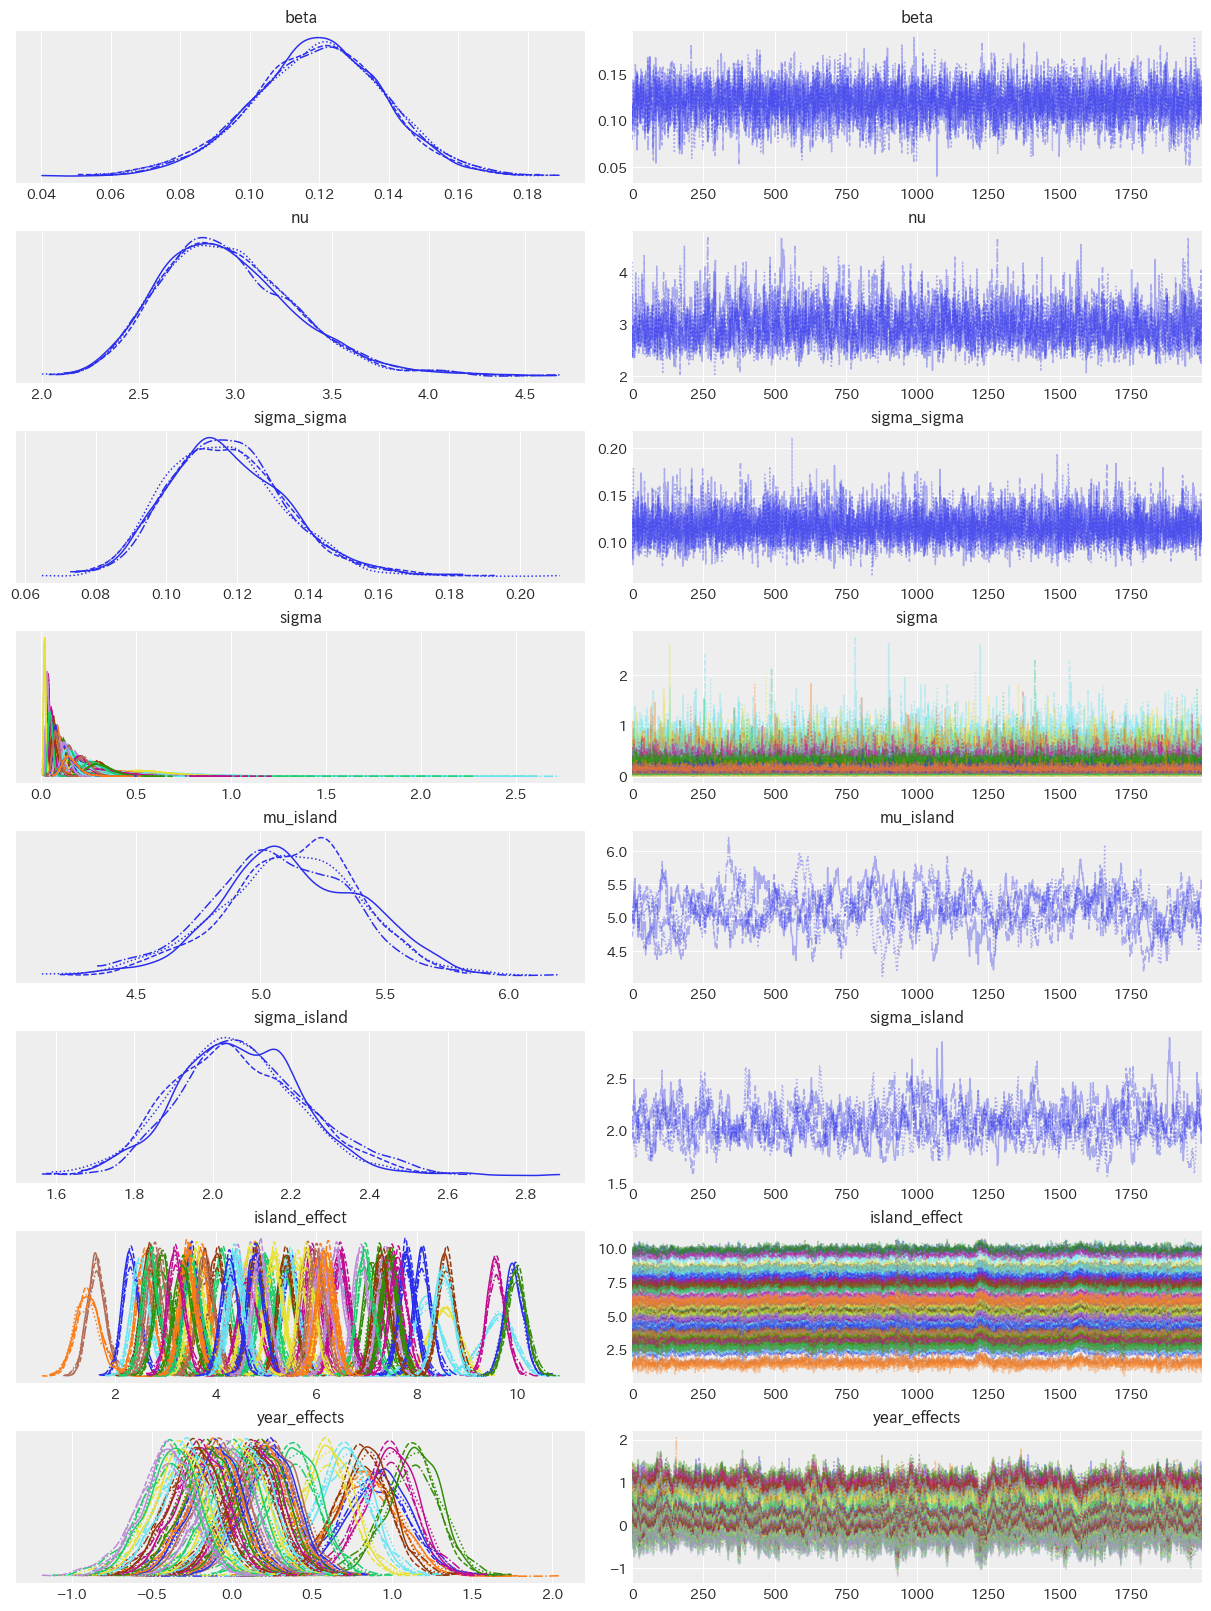

In [51]:
az.plot_trace(trace_h_hetero, var_names=['beta', 'nu', 'sigma_sigma', 'sigma', 'mu_island', 'sigma_island', 'island_effect', 'year_effects']);

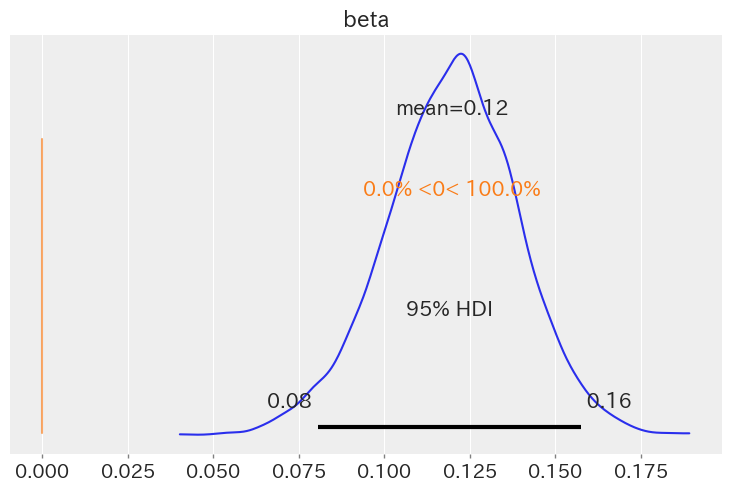

In [52]:
az.plot_posterior(trace_h_hetero, var_names=['beta'], ref_val=0, hdi_prob=.95);

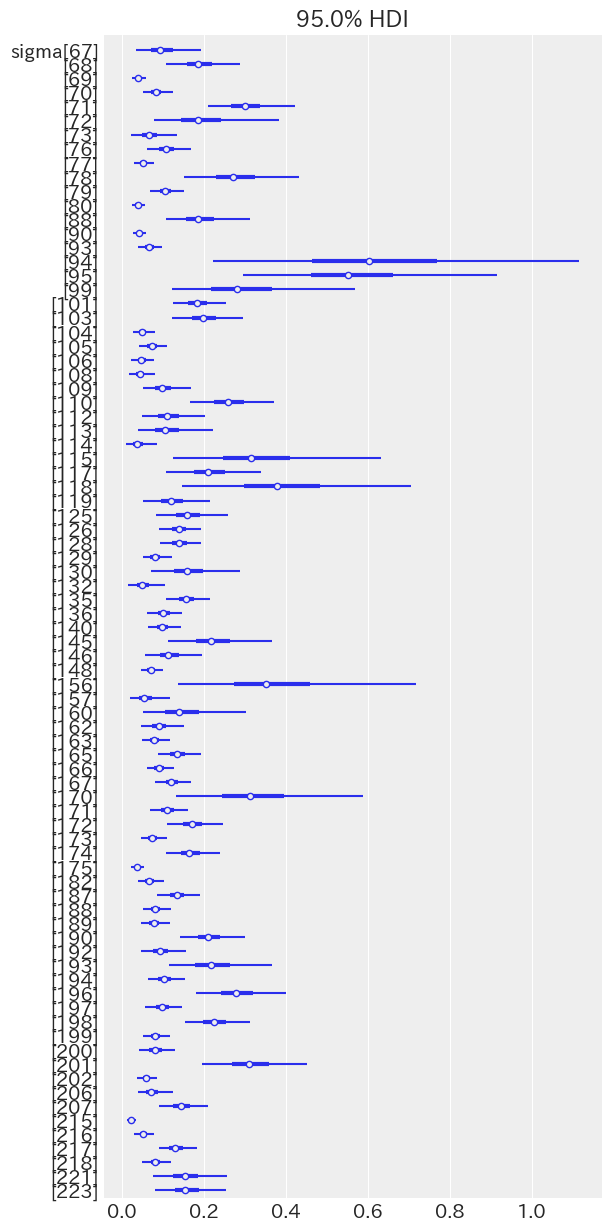

In [53]:
az.plot_forest(trace_h_hetero, var_names=['sigma'], combined=True, hdi_prob=.95);

In [54]:
with model_h_hetero:
    pm.compute_log_likelihood(trace_h_hetero)
az.waic(trace_h_hetero)

Output()

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 8000 posterior samples and 1615 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   603.14    48.89
p_waic      232.26        -

There has been a warning during the calculation. Please check the results.

## 階層ベイズモデル 均一分散

In [32]:
# 島をカテゴリ化
df.island_ids = df.island_ids.astype(str)
df.island_ids = df.island_ids.map(str.strip)
island_ids, mn_island_ids = df.island_ids.factorize()
# 年をカテゴリ化
# df.year = df.year.astype(str)
# df.year = df.year.map(str.strip)
# year, mn_years = df.year.factorize()
year_dummies = dmatrix('C(year)-1', df, return_type='dataframe')

COORDS = {'y': df.index, 'X': df.index, 'island_id': mn_island_ids, 'year': year_dummies.columns}

with pm.Model(coords=COORDS) as model_h_homo:
    # data
    log_pop = pm.Data('log_pop', df['log_pop'], dims='y')
    island_ids = pm.Data('island_ids', island_ids, dims='X')
    treatment = pm.Data('treatment', df['after_treatment'], dims='X')

    # priors
    # random effects
    mu_island = pm.Normal('mu_island', mu=0, sigma=10)
    sigma_island = pm.HalfCauchy('sigma_island', beta=1)
    z_island = pm.Normal('z_island', mu=0, sigma=1, dims='island_id')
    island_effect = pm.Deterministic('island_effect', mu_island + sigma_island * z_island, dims='island_id')

    # fixed effects
    beta = pm.Normal('beta', mu=0, sigma=0.5)
    year_effects = pm.Normal('year_effects', mu=0, sigma=1, dims='year')
    nu = pm.Gamma('nu', alpha=2, beta=0.1)
    sigma = pm.HalfCauchy('sigma', beta=1)

    # expectation
    mu = beta * treatment + island_effect[island_ids] + pm.math.dot(year_dummies, year_effects)

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma, observed=log_pop)

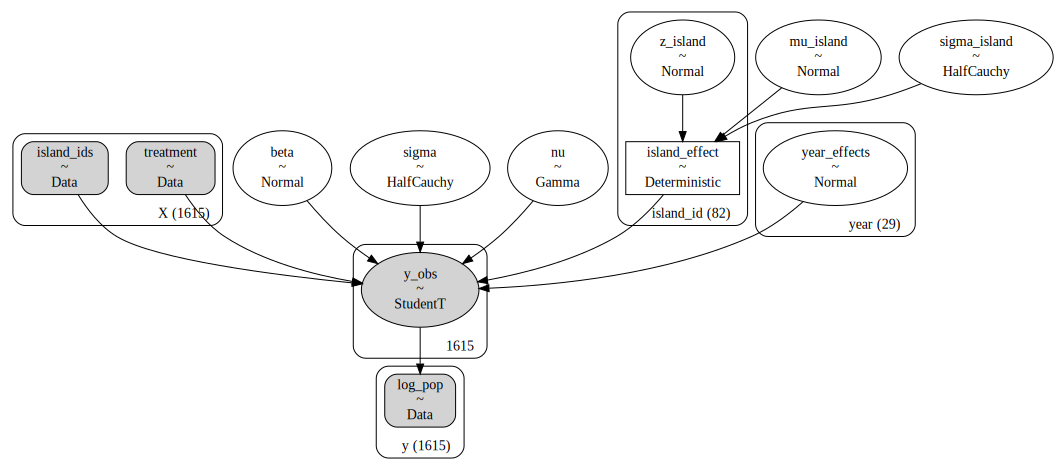

In [33]:
pm.model_to_graphviz(model_h_homo)

In [34]:
with model_h_homo:
    trace_h_homo = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        cores=4,
        target_accept=.9,
        nuts_sampler='numpyro'
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [35]:
az.to_netcdf(trace_h_homo, './mcmc_sample/twfe/trace_h_homo_20250109.nc')

'./mcmc_sample/twfe/trace_h_homo_20250109.nc'

In [36]:
az.summary(trace_h_homo, var_names=['beta', 'sigma', 'nu', 'mu_island', 'sigma_island', 'year_effects'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
beta                         0.124  0.020   0.087    0.161      0.000   
sigma                        0.092  0.004   0.084    0.100      0.000   
nu                           1.664  0.115   1.457    1.886      0.002   
mu_island                    5.579  0.285   5.050    6.109      0.014   
sigma_island                 2.062  0.167   1.756    2.380      0.007   
year_effects[C(year)[1960]]  0.720  0.202   0.352    1.113      0.008   
year_effects[C(year)[1965]]  0.644  0.204   0.242    1.008      0.008   
year_effects[C(year)[1970]]  0.905  0.191   0.541    1.255      0.008   
year_effects[C(year)[1975]]  0.711  0.188   0.340    1.049      0.008   
year_effects[C(year)[1980]]  0.568  0.185   0.209    0.908      0.008   
year_effects[C(year)[1985]]  0.497  0.184   0.159    0.853      0.008   
year_effects[C(year)[1990]]  0.390  0.184   0.047    0.742      0.008   
year_effects[C(year)[1995]]  0.194  0.184  -0.154    0.536      0.008   
year_effects[C(year)[2000]]  0.030  0.183  -0.313    0.375      0.008   
year_effects[C(year)[2001]]  0.069  0.184  -0.263    0.429      0.008   
year_effects[C(year)[2002]]  0.043  0.184  -0.309    0.377      0.008   
year_effects[C(year)[2003]]  0.012  0.184  -0.332    0.360      0.008   
year_effects[C(year)[2004]] -0.012  0.184  -0.355    0.337      0.008   
year_effects[C(year)[2005]] -0.044  0.184  -0.396    0.293      0.008   
year_effects[C(year)[2006]] -0.071  0.183  -0.411    0.280      0.008   
year_effects[C(year)[2007]] -0.104  0.183  -0.456    0.235      0.008   
year_effects[C(year)[2008]] -0.136  0.183  -0.476    0.211      0.008   
year_effects[C(year)[2009]] -0.175  0.183  -0.524    0.167      0.008   
year_effects[C(year)[2010]] -0.200  0.183  -0.544    0.143      0.008   
year_effects[C(year)[2011]] -0.250  0.183  -0.605    0.086      0.008   
year_effects[C(year)[2012]] -0.280  0.184  -0.630    0.062      0.008   
year_effects[C(year)[2013]] -0.296  0.183  -0.643    0.046      0.008   
year_effects[C(year)[2014]] -0.338  0.184  -0.686    0.005      0.008   
year_effects[C(year)[2015]] -0.369  0.183  -0.720   -0.030      0.008   
year_effects[C(year)[2016]] -0.414  0.184  -0.759   -0.067      0.008   
year_effects[C(year)[2017]] -0.456  0.184  -0.793   -0.104      0.008   
year_effects[C(year)[2018]] -0.481  0.184  -0.822   -0.131      0.008   
year_effects[C(year)[2019]] -0.531  0.185  -0.877   -0.183      0.008   
year_effects[C(year)[2020]] -0.537  0.185  -0.888   -0.193      0.008   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
beta                           0.000    3342.0    3463.0   1.00  
sigma                          0.000    3041.0    3196.0   1.00  
nu                             0.002    2961.0    3005.0   1.00  
mu_island                      0.010     405.0     711.0   1.01  
sigma_island                   0.005     603.0     793.0   1.01  
year_effects[C(year)[1960]]    0.006     612.0    1510.0   1.00  
year_effects[C(year)[1965]]    0.006     626.0    1614.0   1.00  
year_effects[C(year)[1970]]    0.006     529.0    1203.0   1.00  
year_effects[C(year)[1975]]    0.006     517.0    1117.0   1.00  
year_effects[C(year)[1980]]    0.006     506.0    1066.0   1.00  
year_effects[C(year)[1985]]    0.006     510.0    1108.0   1.00  
year_effects[C(year)[1990]]    0.006     505.0    1038.0   1.00  
year_effects[C(year)[1995]]    0.006     506.0    1003.0   1.00  
year_effects[C(year)[2000]]    0.006     502.0    1003.0   1.00  
year_effects[C(year)[2001]]    0.006     505.0    1020.0   1.00  
year_effects[C(year)[2002]]    0.006     502.0    1029.0   1.00  
year_effects[C(year)[2003]]    0.006     506.0    1009.0   1.00  
year_effects[C(year)[2004]]    0.006     502.0    1015.0   1.00  
year_effects[C(year)[2005]]    0.006     500.0    1005.0   1.00  
year_effects[C(year)[2006]]    0.006     503.0    1029.0   1.00  
year_effects[C(year)[2007]]    0.006     503.0     990.0   1.00  
year_effects[C(year)[2

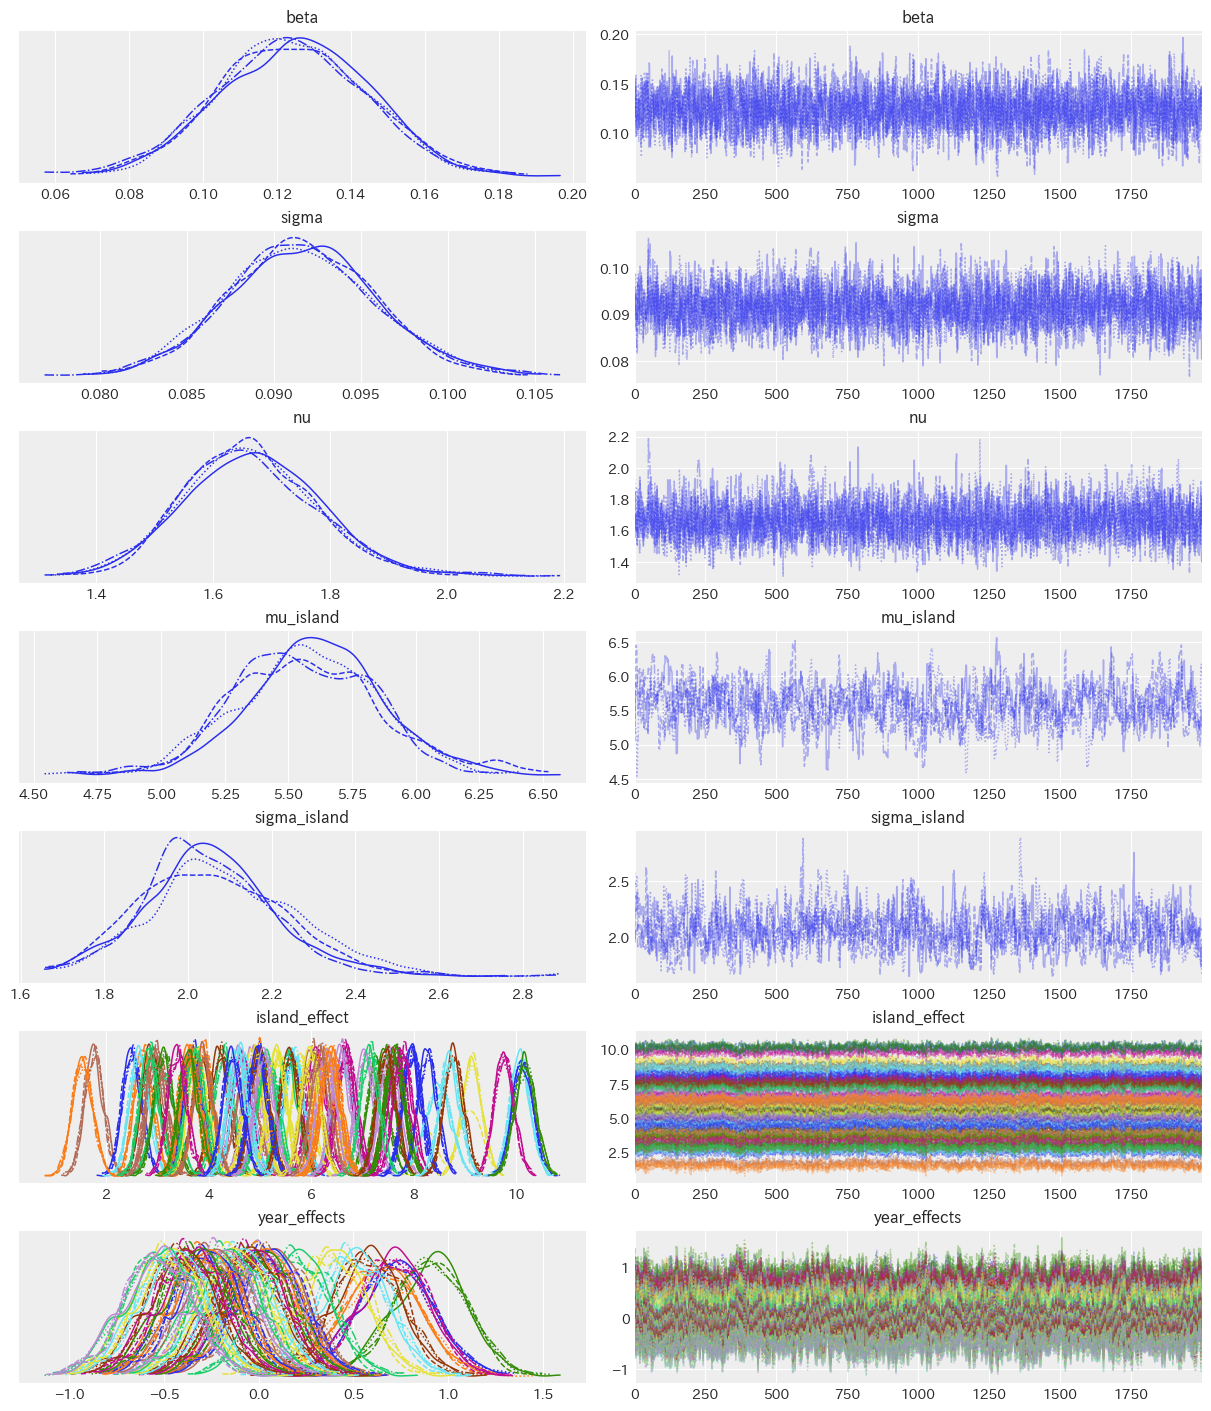

In [37]:
az.plot_trace(trace_h_homo, var_names=['beta', 'sigma', 'nu', 'mu_island', 'sigma_island', 'island_effect', 'year_effects']);

In [38]:
with model_h_homo:
    pm.compute_log_likelihood(trace_h_homo)

Output()

In [39]:
az.waic(trace_h_homo)

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 8000 posterior samples and 1615 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   402.55    51.82
p_waic      200.76        -

There has been a warning during the calculation. Please check the results.

## 階層ベイズモデル 不均一分散 加重最小2乗法

In [57]:
# 島をカテゴリ化
df.island_ids = df.island_ids.astype(str)
df.island_ids = df.island_ids.map(str.strip)
island_ids, mn_island_ids = df.island_ids.factorize()
# 年をダミー化
year_dummies = dmatrix('C(year)-1', df, return_type='dataframe')

COORDS = {'y': df.index, 'X': df.index, 'island_id': mn_island_ids, 'year': year_dummies.columns}

with pm.Model(coords=COORDS) as model_wls:
    # data
    log_pop = pm.Data('log_pop', df['log_pop'], dims='y')
    island_ids = pm.Data('island_ids', island_ids, dims='X')
    treatment = pm.Data('treatment', df['after_treatment'], dims='X')

    # priors
    # random effects
    mu_island = pm.Normal('mu_island', mu=0, sigma=1)
    sigma_island = pm.HalfCauchy('sigma_island', beta=1)
    z_island = pm.Normal('z_island', mu=0, sigma=1, dims='island_id')
    island_effect = pm.Deterministic('island_effect', mu_island + sigma_island * z_island, dims='island_id')

    # fixed effects
    beta = pm.Normal('beta', mu=0, sigma=1)
    year_effect = pm.Normal('year_effect', mu=0, sigma=1, dims='year')
    nu = pm.Gamma('nu', alpha=2, beta=0.1)

    # expectation
    mu = beta * treatment + island_effect[island_ids] + pm.math.dot(year_dummies, year_effect)

    sigma = pm.HalfCauchy('sigma', 0.15)
    sigma_star = pm.Deterministic('sigma_star', sigma/np.sqrt(log_pop))

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma_star, observed=log_pop, dims='y')

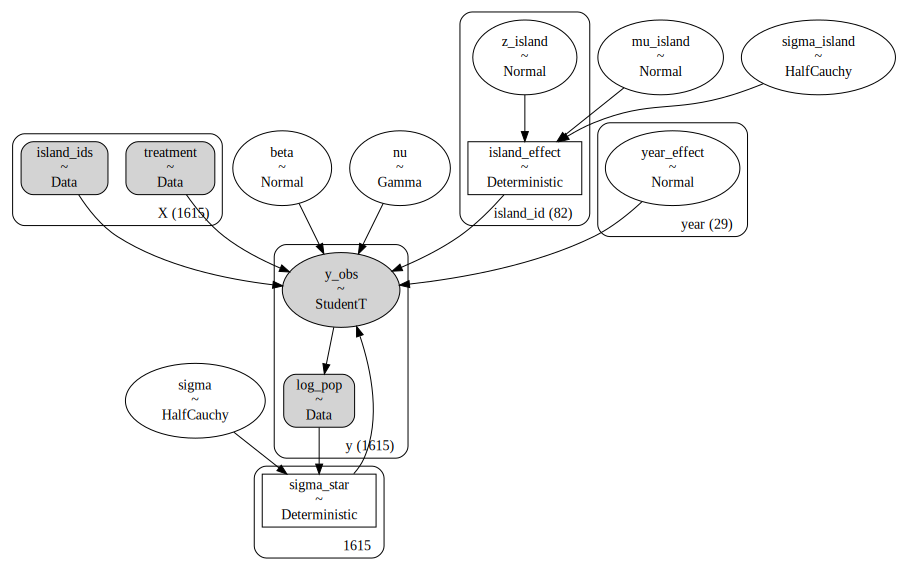

In [58]:
pm.model_to_graphviz(model_wls)

In [59]:
with model_wls:
    trace_wls = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        cores=4,
        target_accept=.9,
        nuts_sampler='numpyro'
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [60]:
az.to_netcdf(trace_wls, './mcmc_sample/twfe/trace_wls_20250109.nc')

'./mcmc_sample/twfe/trace_wls_20250109.nc'

In [66]:
az.summary(trace_wls, var_names=['beta', 'sigma', 'nu', 'mu_island', 'sigma_island'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta          0.111  0.018   0.078    0.146      0.000    0.000    1430.0   
sigma         0.194  0.009   0.178    0.212      0.000    0.000    1431.0   
nu            1.590  0.107   1.396    1.795      0.003    0.002    1473.0   
mu_island     5.155  0.267   4.709    5.722      0.019    0.013     206.0   
sigma_island  2.057  0.158   1.759    2.340      0.010    0.007     262.0   

              ess_tail  r_hat  
beta            1747.0   1.00  
sigma           1892.0   1.00  
nu              1775.0   1.00  
mu_island        292.0   1.01  
sigma_island     508.0   1.02

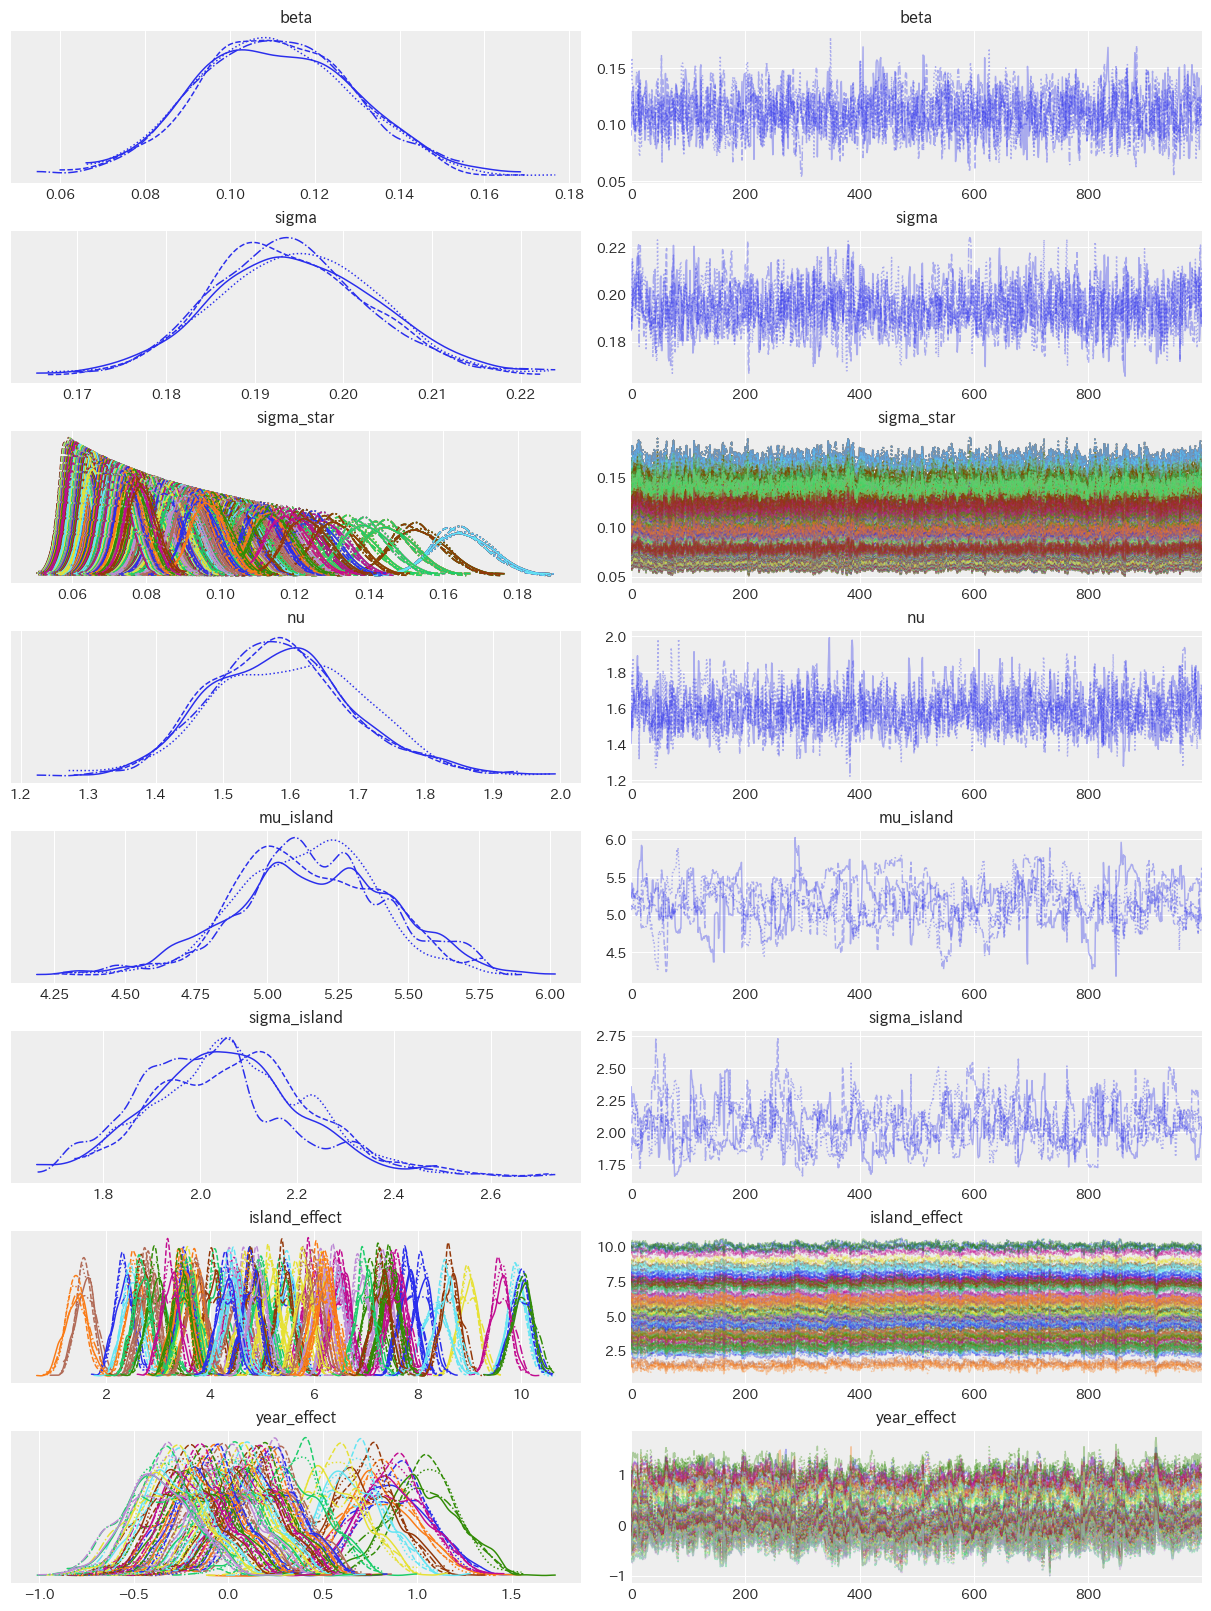

In [65]:
az.plot_trace(trace_wls, var_names=['beta', 'sigma', 'sigma_star', 'nu']);

In [67]:
with model_wls:
    pm.compute_log_likelihood(trace_wls)

Output()

In [68]:
az.waic(trace_wls)

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 1615 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   396.17    52.41
p_waic      214.98        -

There has been a warning during the calculation. Please check the results.